Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [7]:
def decorrelate(data, model):

    # covariance matrix before training
    X = model.forward(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(2000)
    for i in range(2000):
        y = model.forward(data)
        L[i] = model.update()
        model.R -= 1e-1 * model.R.grad
        print(f'iteration {i}\tdecorrelation loss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.forward(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	decorrelation loss: 0.138
iteration 1	decorrelation loss: 0.137
iteration 2	decorrelation loss: 0.136
iteration 3	decorrelation loss: 0.135
iteration 4	decorrelation loss: 0.134
iteration 5	decorrelation loss: 0.133
iteration 6	decorrelation loss: 0.132
iteration 7	decorrelation loss: 0.131
iteration 8	decorrelation loss: 0.130
iteration 9	decorrelation loss: 0.129
iteration 10	decorrelation loss: 0.128
iteration 11	decorrelation loss: 0.127
iteration 12	decorrelation loss: 0.126
iteration 13	decorrelation loss: 0.125
iteration 14	decorrelation loss: 0.124
iteration 15	decorrelation loss: 0.124
iteration 16	decorrelation loss: 0.123
iteration 17	decorrelation loss: 0.122
iteration 18	decorrelation loss: 0.121
iteration 19	decorrelation loss: 0.120
iteration 20	decorrelation loss: 0.119
iteration 21	decorrelation loss: 0.119
iteration 22	decorrelation loss: 0.118
iteration 23	decorrelation loss: 0.117
iteration 24	decorrelation loss: 0.116
iteration 25	decorrelation loss: 0.

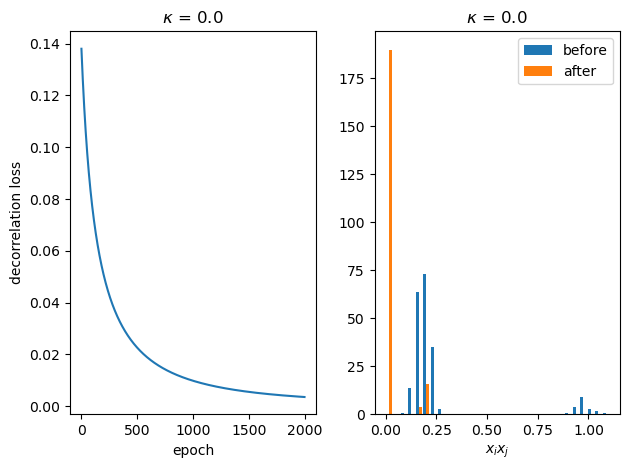

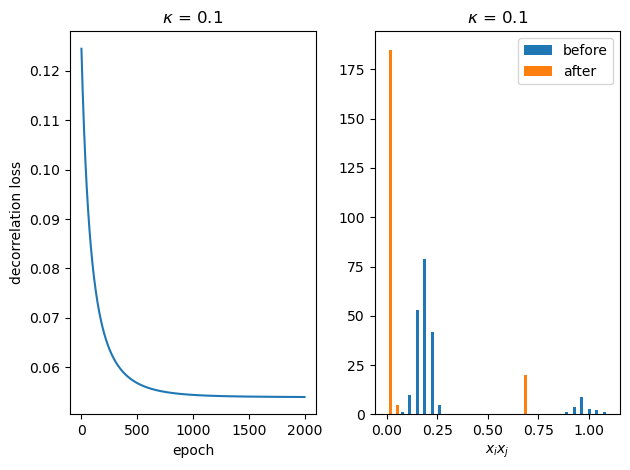

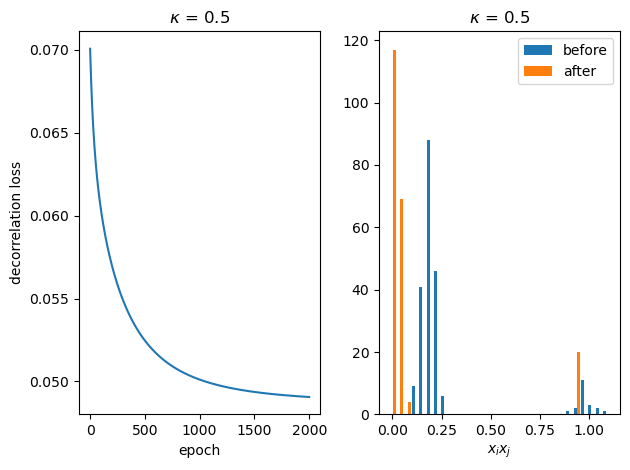

In [12]:
num_samples=1000
num_features=20
num_epochs=1000
kappas = [0.0, 0.1, 0.5]

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

for kappa in kappas:

    # create a decorrelator
    model = Decorrelation(num_features, kappa=kappa)

    L, A1, A2 = decorrelate(data,model) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(L)
    plt.ylabel('decorrelation loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

Decorrelation of correlated input using DecorrelationPatch2d: decorrelate patches and map back to feature maps; why are all resulting values tiny? (also diagonal)

In [2]:
# generate [N, M] correlated input
num_examples=100
in_channels=2
out_channels=2
height=20
width=20
num_features=in_channels*height*width
kernel_size=(5,5)
num_samples=1000
num_epochs=1000
kappas = [0.0, 0.1, 0.25, 0.5]

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

for kappa in kappas:

    # create a convolutional decorrelator
    model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, kappa=kappa)

    L, A1, A2 = decorrelate(data,model) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(L)
    plt.ylabel('decorrelation loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

TypeError: DecorConv2d.__init__() missing 1 required positional argument: 'out_channels'

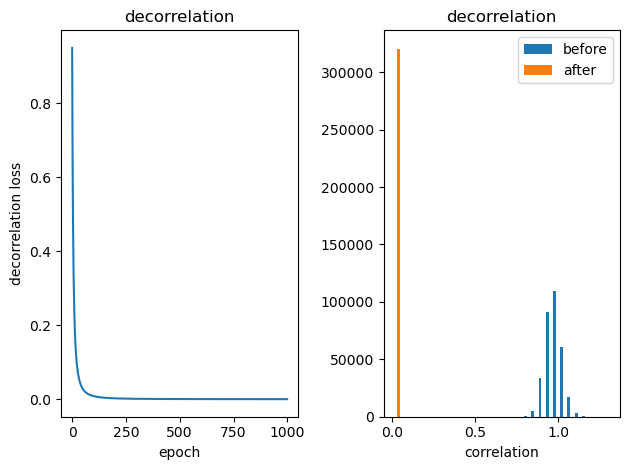

In [ ]:
plt.subplot(1,2,1)
plt.plot(L)
plt.ylabel('decorrelation loss')
plt.xlabel('epoch')
plt.title('whitening' if whiten else 'decorrelation')   
plt.subplot(1,2,2)
plt.hist([lower_triangular(B1, offset=0), lower_triangular(B2, offset=0)], bins=30, label=['before', 'after'])
plt.legend()
plt.xlabel('correlation')
plt.title('whitening' if whiten else 'decorrelation') 
plt.legend();
plt.tight_layout()


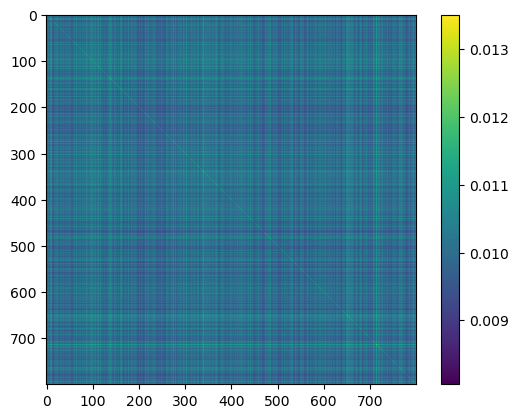

In [ ]:
plt.imshow(B2)
plt.colorbar();

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison